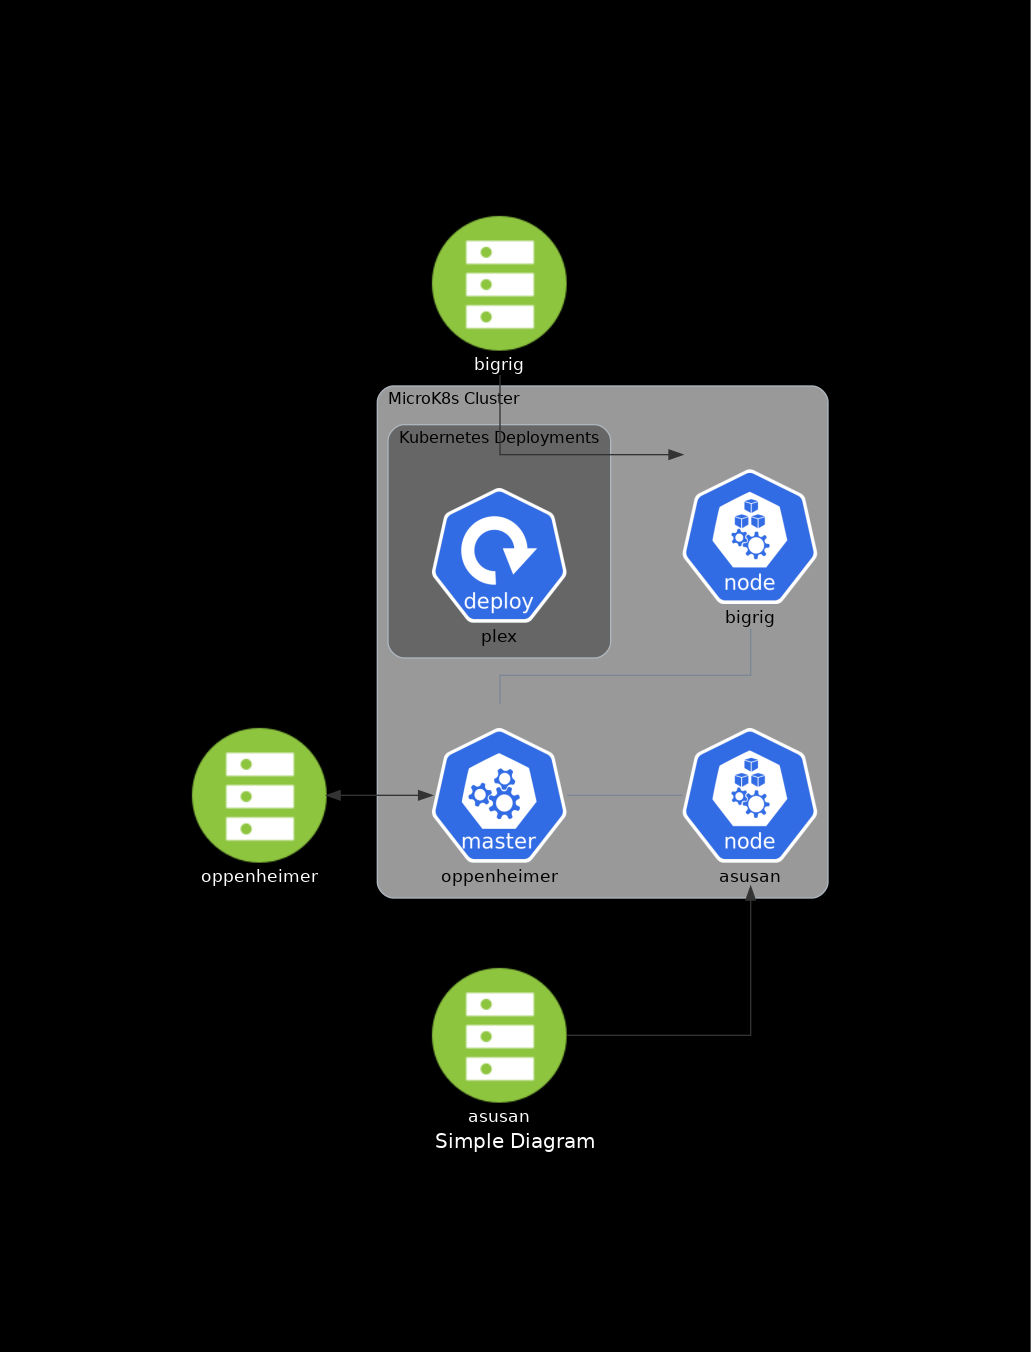

In [28]:
from diagrams               import Diagram, Cluster, Edge
from diagrams.ibm.compute   import BareMetalServer
from diagrams.k8s.infra     import Master, Node
from diagrams.k8s.compute   import Deployment
from diagrams.k8s.storage   import StorageClass

diagram_attr = { "fontcolor": "white", "bgcolor": "black" }
with Diagram("Simple Diagram", graph_attr=diagram_attr) as diag:
    server_attr = { "fontcolor": "white" }
    bigrig      = BareMetalServer("bigrig", **server_attr)
    oppenheimer = BareMetalServer("oppenheimer", **server_attr)
    asusan      = BareMetalServer("asusan", **server_attr)

    cluster_node_attr = { "fontcolor": "black" }
    cluster_attr = { "fontcolor": "black", "bgcolor": "gray60" }
    with Cluster("MicroK8s Cluster", graph_attr=cluster_attr) as microk8s:
        master1 = Master("oppenheimer", **cluster_node_attr)
        node1   = Node("bigrig", **cluster_node_attr)
        node2   = Node("asusan", **cluster_node_attr)
        
        master1     - [node1, node2]
        oppenheimer >> Edge(color="grey20") >> master1
        bigrig      >> Edge(color="grey20") >> node1
        asusan      >> Edge(color="grey20") >> node2

        deploys_cluster_attr = { "bgcolor": "gray40" }
        deploys_attr = { "fontcolor": "white" }
        with Cluster("Kubernetes Deployments", graph_attr=deploys_cluster_attr) as k8s_deployments:
            plex    = Deployment("plex", **cluster_node_attr)
            nfs     = StorageClass("nfs", **cluster_node_attr)

diag